In [6]:
num_qubits_list = [5] # [7] # [7] # [5] # [9]
num_trial = 2 # 1 # 20 # 3 # 1

In [7]:
from qiskit_aer import AerSimulator
from qiskit import Aer
from qiskit import transpile

In [8]:
def change_bin(bit_list) :
    value = 0
    for element in bit_list[::-1]:
        value = value*2
        value += element
    return value


def generate_binaries(n):

    L=[[] for j in range(n)]

    for i in range(pow(2,n-1)) :
        ca = list(bin(i))[2:]
        for j in range(len(ca)) :
            ca[j] = int(ca[j])
        if len(ca) < n-1 :
            ca = [0 for k in range(n - 1 - len(ca))] + ca

        num_one = 0
        for i in range(0,n-1):
            if ca[i] == 1:
                num_one += 1

        #print(num_one)
        num_anc = n-1
        if num_one < n/2:
            for i in range(0,n-1):
                if ca[i] == 1:
                    L[i+1].append(change_bin(ca))
        else: 
            L[0].append(change_bin(ca))
            for i in range(0,n-1):
                if ca[i] == 0:
                    L[i+1].append(change_bin(ca)) 
    return L

In [9]:
from qiskit_aer.noise import NoiseModel, pauli_error

p_err = 0.5 # 0.4 # 0.2 # 0.1 # 0.03 # 0.25 # 0.1 # 0. 

error_inv_x = pauli_error([('X', 1 - p_err), ('I', p_err)])
error_inv_z = pauli_error([('Z', 1 - p_err), ('I', p_err)])



import qiskit.quantum_info as qi

x_op = qi.Operator([[0,1],[1,0]])
z_op = qi.Operator([[1,0],[0,-1]])

noise_model = NoiseModel()

# noise_model.add_all_qubit_quantum_error(error_x, 'bit-flip')
noise_model.add_all_qubit_quantum_error(error_inv_x, 'bit-flip')
noise_model.add_all_qubit_quantum_error(error_inv_z, 'phase-flip')

noise_model.add_basis_gates(['unitary'])

# noise_model.add_quantum_error(error_x, 'x', [1])

In [10]:
from qiskit_ibm_provider import IBMProvider

# Save your credentials on disk.
# IBMProvider.save_account(token='<IBM Quantum API key>')

provider = IBMProvider(instance='q-info-hackathon/team-8/main')

In [11]:
backend = provider.get_backend('ibm_canberra') # 'ibm_hanoi' # 'ibmq_lima'

In [12]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
import numpy as np
from qiskit_aer.noise import pauli_error
from tqdm import tqdm

def string_1s(n):
    ssss = '1'
    for i in range(n-1):
        ssss+='1'
    return ssss

def string_0s(n):
    ssss = '0'
    for i in range(n-1):
        ssss+='0'
    return ssss

def return_to_bits(bit_string) :
    b = int(bit_string,2)
    return b

error_type = 'phase-flip' # 'bit-flip'
shots_num = 10000

counts_list_list = []
job_id_list_list = []
for n in num_qubits_list:
    
    ##### number of qubits #####

    ##### number of shots #####

    ##### circuit setting ######
    q0 = QuantumRegister(n, 'qm') # message
    q1 = QuantumRegister(n-1, 'qa') # ancillar
    c0 = ClassicalRegister(n, 'cm')
    c1 = ClassicalRegister(n-1, 'ca')
    circuit = QuantumCircuit(q0, q1, c0, c1)

    ##### encoding a physical qubit into a logical qubit #####
    for i in range(1,n):
        circuit.cx(q0[0],q0[i])
        
    ##### convert phase flip into bit flip #####
    if error_type == 'phase-flip':
        circuit.h(q0)
    circuit.barrier(q0, q1)
    
    ##### introduce errors #####
    if error_type == 'phase-flip':
#         circuit.unitary(z_op, q0, label='phase-flip')
        pass
    elif error_type == 'bit-flip':
#         circuit.unitary(x_op, q0, label='bit-flip')
        pass
    circuit.barrier(q0, q1)
    
    ##### convert phase flip into bit flip #####
    if error_type == 'phase-flip':
        circuit.h(q0)
    
    ##### make ancilla qubits #####
    for i in range(0, n-1):
        circuit.cx(q0[0], q1[i])
        circuit.cx(q0[i+1], q1[i])
    circuit.barrier(q0, q1)
    

    ##### measure ancillas #####
    circuit.measure(q1,c1)
    circuit.barrier(q0,q1)

    ##### correction circuit #####
    num_list_list = generate_binaries(n)
    for j_qubit, num_list in enumerate(num_list_list):
        for num in num_list:
            circuit.x(q0[j_qubit]).c_if(c1,num)
        
    circuit.barrier(q0,q1)
    
    ##### result measurement #####
    circuit.measure(q0,c0)

    ##################################################
#     backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)

#     from qiskit.providers.fake_provider  import FakeMumbai
#     backend = FakeMumbai()

#     backend = AerSimulator()
#     backend = AerSimulator(noise_model=noise_model)

    tcirc = transpile(circuit, backend)

    ##################################################

    n_data = []
    counts_list = []
    job_id_list = []
    for iteration_number in tqdm(range(num_trial)):
        
#         iteration_data = []
        
#         string_0 = string_0s(n)
#         string_1 = string_1s(n)
        
        
        job = backend.run(tcirc, shots=shots_num)
        job_id_list.append(job.job_id())
        
    job_id_list_list.append(job_id_list)
    
#         result = job.result()
#         counts = result.get_counts(tcirc)
        
#         counts_list.append(counts)
#         print(f"n={n}: {counts}")
    
    counts_list_list.append(counts_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


In [14]:
job_id_list_list

[['cia62apg5luj4cjj0g60', 'cia62b902cefj73onht0']]

In [15]:
job_id_list_list[0][0]

'cia62apg5luj4cjj0g60'

In [16]:
figname_circuit = 'circuit-test-021.png'
# circuit.draw('mpl', filename=figname_circuit)

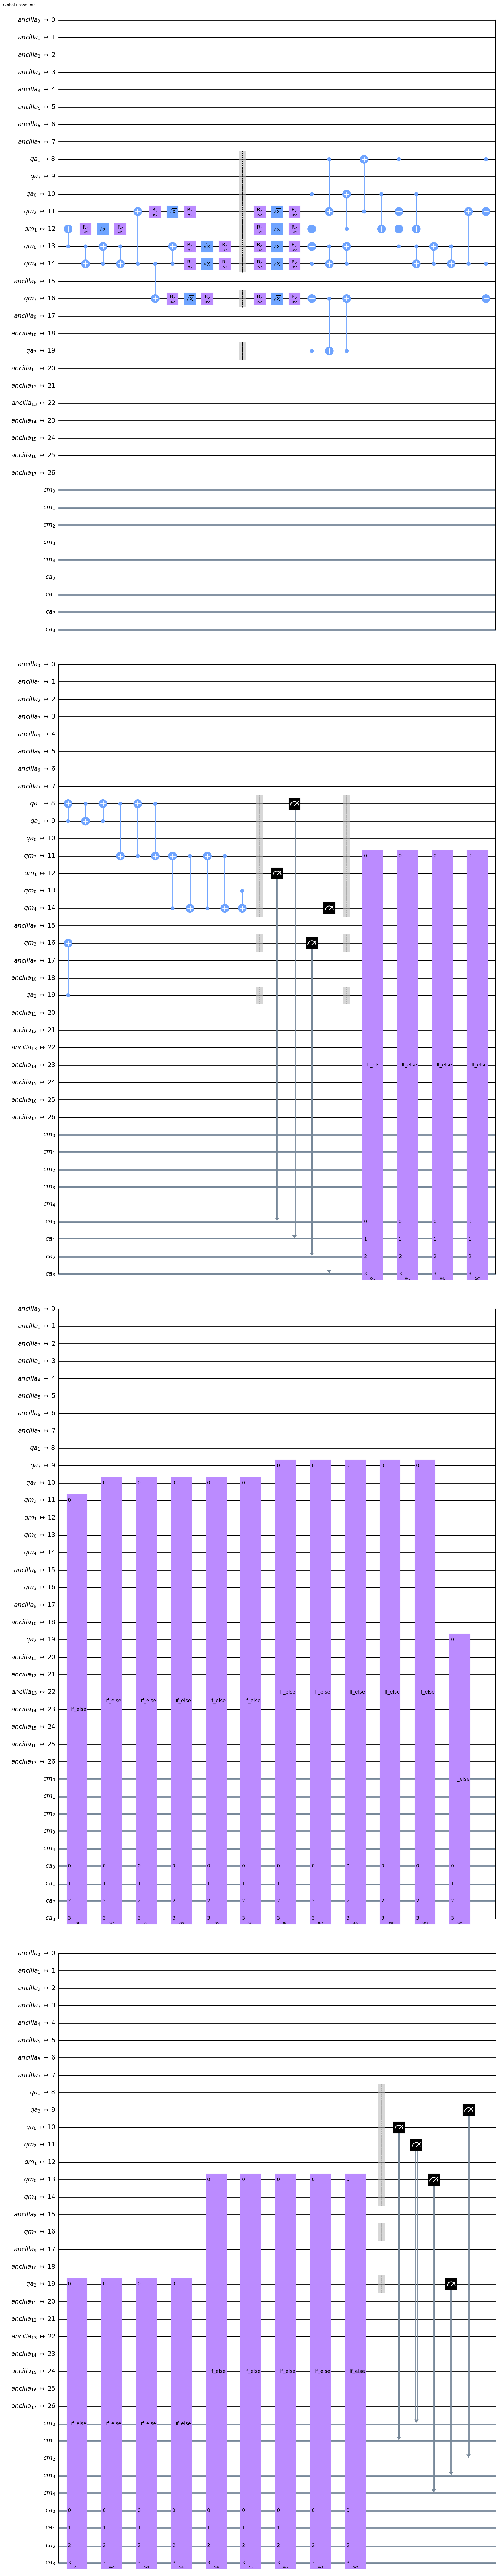

In [17]:
tcirc.draw('mpl', filename='transpiled_'+figname_circuit)

In [30]:
# counts = counts_list_list[0][0]

In [53]:
def counts_to_merged_counts(counts):

    data_list = set([k.split()[-1] for k in counts.keys()])
    word_lengths = [len(word) for word in data_list]
    nq = word_lengths[0]
#     nq = num_qubits_list[0]
    assert all([nq == word for word in word_lengths])

    all_0 = '0' * nq
    all_1 = '1' * nq
    counts_data = {all_0:0, all_1:0, 'etc':0}
    for k, v in counts.items():
        if k[-nq:] == all_0:
            counts_data[all_0] += v
        elif k[-nq:] == all_1:
            counts_data[all_1] += v
        else:
            counts_data['etc'] += v
            
#     return counts_data
    return counts_data[all_0], counts_data[all_1], counts_data['etc']

In [54]:
# counts_to_logical_err

# counts_data

In [55]:
job_id_list_list

[['cia5mn161rck8jrqq180']]

In [56]:
job = provider.backend.retrieve_job(job_id_list_list[0][0])

In [57]:
job.backend

<bound method JobV1.backend of <IBMCircuitJob('cia5mn161rck8jrqq180')>>

In [58]:
job.backend_options()

{'meas_level': 2,
 'init_qubits': True,
 'meas_return': 'avg',
 'shots': 10000,
 'memory': False}

In [59]:
job.done()

True

In [60]:
job.metadata

{}

In [61]:
result = job.result()

In [62]:
counts = result.get_counts(tcirc)

In [63]:
counts_list.append(counts)
print(f"n={n}: {counts}")

n=3: {'00 000': 5569, '00 001': 530, '10 000': 294, '10 001': 60, '10 010': 3, '10 011': 8, '10 100': 390, '10 101': 383, '10 110': 5, '10 111': 34, '11 000': 925, '11 001': 440, '11 010': 4, '11 011': 13, '11 100': 18, '11 101': 49, '11 111': 22, '00 010': 40, '00 011': 6, '00 100': 101, '00 101': 81, '00 110': 4, '00 111': 41, '01 000': 127, '01 001': 21, '01 010': 203, '01 011': 425, '01 100': 3, '01 101': 20, '01 110': 19, '01 111': 162}


In [64]:
# job.result()

In [65]:
from qiskit.visualization import plot_histogram

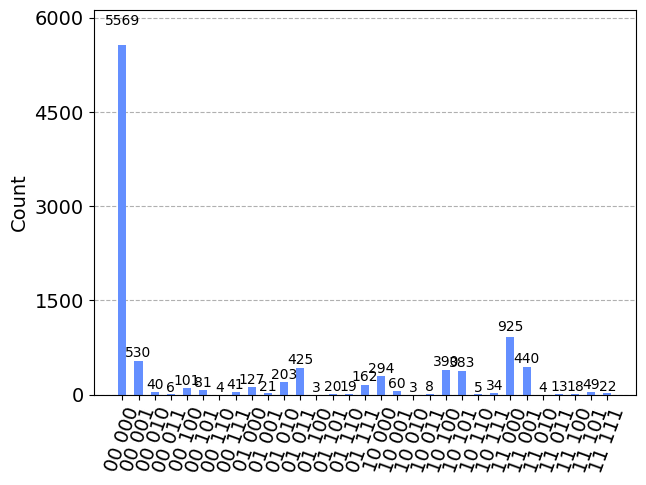

In [66]:
plot_histogram(counts)

In [67]:
counts_merged = counts_to_merged_counts(counts)

In [68]:
counts_merged

(6915, 259, 2826)

In [69]:
sum(counts_merged)

10000

In [72]:
# counts_merged['0'*num_qubits_list[0]]

In [73]:
counts_trials = np.empty((num_trial,3), dtype=np.int64)
# counts_trials = np.empty((num_trial,2), dtype=np.int64)

for j_trial in range(num_trial):
    merged_counts = counts_to_merged_counts(counts_list_list[0][j_trial])
    counts_trials[j_trial] = merged_counts
    
counts_trials

array([[6915,  259, 2826]], dtype=int64)

In [75]:
# error_type = 'none'

In [76]:
# np.save(f'counts_all0-all1-etc_{error_type}_p-{p_err:.3g}_numqubits-{num_qubits_list[0]}_test-016.npy', counts_trials)

In [17]:
# assert sum(counts_data.values()) == shots_num

In [ ]:
p_logical_err = 1 - counts_data[all_0] / sum(counts_data.values())

In [ ]:
nq_div_2, r_ = divmod(nq, 2)
assert r_ == 1

In [ ]:
nq_div_2

In [17]:
from math import comb

In [18]:
comb(3,2)

3

In [19]:
p_logical_err_theor = 0.
for jj in range(nq_div_2+1):
    p_logical_err_theor += comb(nq,jj) * pow(p_err,nq-jj) * pow(1-p_err,jj)

In [20]:
p_logical_err, p_logical_err_theor

(0.027900000000000036, 0.028000000000000008)

In [21]:
from qiskit.visualization import plot_histogram

In [24]:
# plot_histogram(counts_list_list[0][0], filename=f'hist-7-rep-p-{p_err:.3g}-test-002.png')

In [23]:
tcirc.draw()

░ ┌──────────┐ ░                      ░        ░ ┌───────┐»
qm_0: ──■────■───░─┤ bit-flip ├─░───■────■─────────────░────────░─┤ Rz(π) ├»
      ┌─┴─┐  │   ░ ├──────────┤ ░   │    │             ░        ░ └───╥───┘»
qm_1: ┤ X ├──┼───░─┤ bit-flip ├─░───┼────┼────■────────░────────░─────╫────»
      └───┘┌─┴─┐ ░ ├──────────┤ ░   │    │    │        ░        ░     ║    »
qm_2: ─────┤ X ├─░─┤ bit-flip ├─░───┼────┼────┼────■───░────────░─────╫────»
           └───┘ ░ └──────────┘ ░ ┌─┴─┐  │  ┌─┴─┐  │   ░ ┌─┐    ░     ║    »
qa_0: ───────────░──────────────░─┤ X ├──┼──┤ X ├──┼───░─┤M├────░─────╫────»
                 ░              ░ └───┘┌─┴─┐└───┘┌─┴─┐ ░ └╥┘┌─┐ ░     ║    »
qa_1: ───────────░──────────────░──────┤ X ├─────┤ X ├─░──╫─┤M├─░─────╫────»
                 ░              ░      └───┘     └───┘ ░  ║ └╥┘ ░     ║    »
cm: 3/════════════════════════════════════════════════════╬══╬════════╬════»
                                                          ║  ║     ┌──╨──┐ »
ca: 2/════════════════════════════════════════════════════╩══╩═════╡ 0x3 ╞═»
                                                          0  1     └─────┘ »
«       ┌────┐┌────────┐ ┌────┐┌────────┐                                 »
«qm_0: ─┤ √X ├┤ Rz(2π) ├─┤ √X ├┤ Rz(3π) ├─────────────────────────────────»
«       └─╥──┘└───╥────┘ └─╥──┘└───╥────┘┌───────┐ ┌────┐┌────────┐ ┌────┐»
«qm_1: ───╫───────╫────────╫───────╫─────┤ Rz(π) ├─┤ √X ├┤ Rz(2π) ├─┤ √X ├»
«         ║       ║        ║       ║     └───╥───┘ └─╥──┘└───╥────┘ └─╥──┘»
«qm_2: ───╫───────╫────────╫───────╫─────────╫───────╫───────╫────────╫───»
«         ║       ║        ║       ║         ║       ║       ║        ║   »
«qa_0: ───╫───────╫────────╫───────╫─────────╫───────╫───────╫────────╫───»
«         ║       ║        ║       ║         ║       ║       ║        ║   »
«qa_1: ───╫───────╫────────╫───────╫─────────╫───────╫───────╫────────╫───»
«         ║       ║        ║       ║         ║       ║       ║        ║   »
«cm: 3/═══╬═══════╬════════╬═══════╬═════════╬═══════╬═══════╬════════╬═══»
«      ┌──╨──┐ ┌──╨──┐  ┌──╨──┐ ┌──╨──┐   ┌──╨──┐ ┌──╨──┐ ┌──╨──┐  ┌──╨──┐»
«ca: 2/╡ 0x3 ╞═╡ 0x3 ╞══╡ 0x3 ╞═╡ 0x3 ╞═══╡ 0x1 ╞═╡ 0x1 ╞═╡ 0x1 ╞══╡ 0x1 ╞»
«      └─────┘ └─────┘  └─────┘ └─────┘   └─────┘ └─────┘ └─────┘  └─────┘»
«                                                            ░ ┌─┐      
«qm_0: ──────────────────────────────────────────────────────░─┤M├──────
«      ┌────────┐                                            ░ └╥┘┌─┐   
«qm_1: ┤ Rz(3π) ├────────────────────────────────────────────░──╫─┤M├───
«      └───╥────┘┌───────┐ ┌────┐┌────────┐ ┌────┐┌────────┐ ░  ║ └╥┘┌─┐
«qm_2: ────╫─────┤ Rz(π) ├─┤ √X ├┤ Rz(2π) ├─┤ √X ├┤ Rz(3π) ├─░──╫──╫─┤M├
«          ║     └───╥───┘ └─╥──┘└───╥────┘ └─╥──┘└───╥────┘ ░  ║  ║ └╥┘
«qa_0: ────╫─────────╫───────╫───────╫────────╫───────╫──────░──╫──╫──╫─
«          ║         ║       ║       ║        ║       ║      ░  ║  ║  ║ 
«qa_1: ────╫─────────╫───────╫───────╫────────╫───────╫──────░──╫──╫──╫─
«          ║         ║       ║       ║        ║       ║      ░  ║  ║  ║ 
«cm: 3/════╬═════════╬═══════╬═══════╬════════╬═══════╬═════════╩══╩══╩═
«       ┌──╨──┐   ┌──╨──┐ ┌──╨──┐ ┌──╨──┐  ┌──╨──┐ ┌──╨──┐      0  1  2 
«ca: 2/═╡ 0x1 ╞═══╡ 0x2 ╞═╡ 0x2 ╞═╡ 0x2 ╞══╡ 0x2 ╞═╡ 0x2 ╞══════════════
«       └─────┘   └─────┘ └─────┘ └─────┘  └─────┘ └─────┘